<a href="https://colab.research.google.com/github/OldGoose/ORA-Project-Santa-2021---The-Merry-Movie-Montage/blob/main/Santa_2021_TSP_LKH_Original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data (without preprocessing) with LKH

In this notebook, we use 4920 which is not mandatory to our initial data. The flowchart as below:
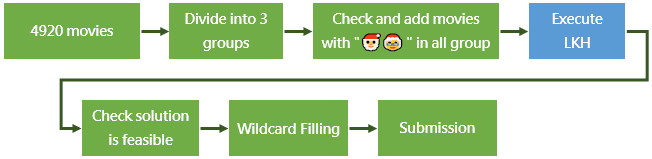

#### REFERENCES
https://www.kaggle.com/cdeotte/santa-2021-tsp-baseline-2500  <br />
https://www.kaggle.com/yosshi999/wildcard-postprocessing-using-dynamic-programming

### Import Package

In [1]:
import itertools
import random
from random import shuffle
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Santa2021') 
!wget http://webhotel4.ruc.dk/~keld/research/LKH-3/LKH-3.0.7.tgz
!tar xvfz LKH-3.0.7.tgz
!cd LKH-3.0.7; make

Mounted at /content/drive
--2022-01-14 01:55:34--  http://webhotel4.ruc.dk/~keld/research/LKH-3/LKH-3.0.7.tgz
Resolving webhotel4.ruc.dk (webhotel4.ruc.dk)... 130.225.220.230
Connecting to webhotel4.ruc.dk (webhotel4.ruc.dk)|130.225.220.230|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2315763 (2.2M) [application/x-gzip]
Saving to: ‘LKH-3.0.7.tgz.18’

LKH-3.0.7.tgz.18    100%[===================>]   2.21M   229KB/s    in 11s     

2022-01-14 01:55:46 (214 KB/s) - ‘LKH-3.0.7.tgz.18’ saved [2315763/2315763]

LKH-3.0.7/
LKH-3.0.7/pr2392.par
LKH-3.0.7/whizzkids96.atsp
LKH-3.0.7/Makefile
LKH-3.0.7/whizzkids96.par
LKH-3.0.7/pr2392.tsp
LKH-3.0.7/DOC/
LKH-3.0.7/README.txt
LKH-3.0.7/SRC/
LKH-3.0.7/SRC/Penalty_CVRPTW.c
LKH-3.0.7/SRC/RestoreTour.c
LKH-3.0.7/SRC/SolveKMeansSubproblems.c
LKH-3.0.7/SRC/IsCommonEdge.c
LKH-3.0.7/SRC/Penalty_TSPPD.c
LKH-3.0.7/SRC/ReadProblem.c
LKH-3.0.7/SRC/BestKOptMove.c
LKH-3.0.7/SRC/Distance_SPECIAL.c
LKH-3.0.7/SRC/Penalty_TSPDL.c
LKH-3.0.

### 1. Divide into 3 groups
From this formula $𝑝_𝑘^𝑛 = \frac{𝑛!}{(𝑛−𝑘)!}$ we can get the following seven symbols (🎅🤶🦌🧝🎄🎁🎀) with a total of 5040 permutations (ie, a total of 5040 movie)
Due to the constrain of the problem, there are a total of 120 movies starting with these 🎅🤶 two symbols, and we have to put them into each group.
After deducting those 120 films, we divide the remaining 4920 films into three equal parts.

In [2]:
LETTERS = list(map(str,range(1,8)))
permutations = [''.join(x) for x in itertools.permutations(LETTERS)]
mandatory = [x for x in permutations if x.startswith('12')]
non_mandatory = [x for x in permutations if not x.startswith('12')]
random.shuffle(non_mandatory)
print('There are',len(permutations),'movies')
print('In addition',len(mandatory),'which movie starting with 🎅🤶 must appear in each group.')

There are 5040 movies
In addition 120 which movie starting with 🎅🤶 must appear in each group.


In [3]:
#find the split point
split_id = [len(non_mandatory) // 3, len(non_mandatory)*2//3]
t1, t2 = split_id

adjust1 = 0
adjust2 = 0
group1 = non_mandatory[:t1-adjust1] + mandatory
group2 = non_mandatory[t1-adjust1:t2+adjust2] + mandatory
group3 = non_mandatory[t2+adjust2:] + mandatory

len(group1), len(group2), len(group3)

(1760, 1760, 1760)

### 3. Check and add movies with "🎅🤶" in all group.

In [4]:
all_permutations = [''.join(x) for x in itertools.permutations(['1','2','3','4','5','6','7'], 7)]

for p in all_permutations:
    if p not in group1 and p not in group2 and p not in group3:
        print(p)

### 4.Execute LKH

In [5]:
def hamming_distance(str1, str2):
    return sum( (c1!=c2) for c1, c2 in zip(str1, str2))

def offset(s1, s2):
    assert(len(s1)==len(s2))
    ln = len(s1)
    j = ln
    for k in range(0,ln):
        if hamming_distance(s1[k:],s2[:7-k])==0:
            j=k
            break
    return j


def get_tsp_solution(group):
    
    # CREATE DISTANCE MATRIX
    SIZE = len(group)
    M = np.zeros((SIZE, SIZE), dtype='int8')
    for j in range(SIZE):
        #if j%25==0: print(j,', ',end='')
        for k in range(SIZE):
            M[j,k] = offset(group[j],group[k])
            
    # WRITE PROBLEM FILE
    f = open(f'group.par','w')
    f.write("PROBLEM_FILE = ../distances.atsp\n")
    f.write("TOUR_FILE = ../output.txt\n")
    f.write(f"OPTIMUM = {SIZE}\n")
    f.write("MOVE_TYPE = 5\n")
    f.write("PATCHING_C = 3\n")
    f.write("PATCHING_A = 2\n")
    f.write("RUNS = 10\n")
    f.write("TIME_LIMIT = 600\n") #seconds
    f.close()
    
    # WRITE PARAMETER FILE
    f = open(f'distances.atsp','w')
    f.write("NAME: distances\n")
    f.write("TYPE: ATSP\n")
    f.write("COMMENT: Asymmetric CTSP\n")
    f.write(f"DIMENSION: {SIZE}\n")
    f.write("EDGE_WEIGHT_TYPE: EXPLICIT\n")
    f.write("EDGE_WEIGHT_FORMAT: FULL_MATRIX\n")
    f.write("EDGE_WEIGHT_SECTION\n")
    for j in range(SIZE):
        #if j%25==0: print(j,', ',end='')
        for k in range(SIZE):
            f.write(f"{M[j,k]:2d} ") 
        f.write("\n")
    f.close()
    
    # EXECUTE TSP SOLVER
    !cd LKH-3.0.7; ./LKH ../group.par
    
    # READ RESULTING ORDER
    with open('output.txt') as f:
        lines = f.readlines()
    for i,ln in enumerate(lines):
        if 'TOUR_SECTION' in ln: break
    perms = [int(x[:-1]) for x in lines[i+1:-2] ]
    
    # CREATE STRING
    result = group[ perms[0]-1 ]
    for k in range(1,len(perms)):
        s1 = group[ perms[k-1]-1 ]
        s2 = group[ perms[k]-1 ]
        d = offset(s1,s2)
        assert(d!=0)
        result += s2[-d:]
    
    return result

In [6]:
starttime = datetime.datetime.now()
def print_header(x):
    print(); print()
    print('Computing String',x)
    print('='*25); print()

print_header(1)
string1 = get_tsp_solution(group1)
print_header(2)
string2 = get_tsp_solution(group2)
print_header(3)
string3 = get_tsp_solution(group3)



Computing String 1

PARAMETER_FILE = ../group.par
Reading PROBLEM_FILE: "../distances.atsp" ... done
ASCENT_CANDIDATES = 50
BACKBONE_TRIALS = 0
BACKTRACKING = NO
# BWTSP =
# CANDIDATE_FILE =
CANDIDATE_SET_TYPE = ALPHA
# DISTANCE =
# DEPOT =
# EDGE_FILE =
EXCESS = 0.000568182
EXTERNAL_SALESMEN = 0
EXTRA_CANDIDATES = 0 
EXTRA_CANDIDATE_SET_TYPE = QUADRANT
GAIN23 = YES
GAIN_CRITERION = YES
INITIAL_PERIOD = 1760
INITIAL_STEP_SIZE = 1
INITIAL_TOUR_ALGORITHM = WALK
# INITIAL_TOUR_FILE = 
INITIAL_TOUR_FRACTION = 1.000
# INPUT_TOUR_FILE = 
KICK_TYPE = 0
KICKS = 1
# MAX_BREADTH =
MAKESPAN = NO
MAX_CANDIDATES = 5 
MAX_SWAPS = 3520
MAX_TRIALS = 3520
# MERGE_TOUR_FILE =
MOVE_TYPE = 5 
# MTSP_MIN_SIZE =
# MTSP_MAX_SIZE =
# MTSP_OBJECTIVE =
# MTSP_SOLUTION_FILE = 
NONSEQUENTIAL_MOVE_TYPE = 9
OPTIMUM = 1760
# OUTPUT_TOUR_FILE = 
PATCHING_A = 2 
PATCHING_C = 3 
# PI_FILE = 
POPMUSIC_INITIAL_TOUR = NO
POPMUSIC_MAX_NEIGHBORS = 5
POPMUSIC_SAMPLE_SIZE = 10
POPMUSIC_SOLUTIONS = 50
POPMUSIC_TRIALS = 1
# P

### 5. Check solution is feasible

In [7]:
all_permutations = [''.join(x) for x in itertools.permutations(['1','2','3','4','5','6','7'], 7)]

for p in all_permutations:
    if p not in string1 and p not in string2 and p not in string3:
        print(p)
              
for p in mandatory:
    if p not in string1 and p not in string2 and p not in string3:
        print(p)
#No News is good news.

In [8]:
result_list = [string1, string2, string3]
for i in range(3):
  print('The length for group' + str(i+1) + ' without wildcards ' +  str(len(result_list[i])))

The length for group1 without wildcards 4045
The length for group2 without wildcards 4106
The length for group3 without wildcards 4125


In [9]:
sub = pd.DataFrame()
sub['schedule'] = [string1, string2, string3]
schedule = sub.schedule.tolist()

### 6. Using Dynamic Programming to filling the 🌟

#### Create Cost martix

In [10]:
perms = list(map(lambda p: "".join(p), itertools.permutations("1234567")))
perm2id = {p: i for i, p in enumerate(perms)}

perms_arr = np.array([list(map(int, p)) for p in perms])
perms_arr.shape

perms_onehot = np.eye(7)[perms_arr-1, :].transpose(0, 2, 1)
assert np.allclose(perms_onehot[:,0,:].astype(np.int64), (perms_arr == 1).astype(np.int64))

must_match_left2right = np.array([-1, -1, -1, -1, -1, -1, -1, 7, 6, 5, 4, 3, 2, 1, 0])
must_match_right2left = np.array([0, 1, 2, 3, 4, 5, 6, 7, -1, -1, -1, -1, -1, -1, -1])
cost_ifmatch = np.array([7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7])

M = F.conv2d(
    F.pad(torch.Tensor(perms_onehot[:, None, :, :]), (7, 7)),
    torch.Tensor(perms_onehot[:, None, :, :]),
    padding="valid"
).squeeze().numpy()

must_match_left2right = np.array([-1, -1, -1, -1, -1, -1, -1, 7, 6, 5, 4, 3, 2, 1, 0])
must_match_left2right_wild = np.array([-1, -1, -1, -1, -1, -1, -1, 6, 5, 4, 3, 2, 1, 0, 0])

cost_ifmatch = np.array([7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7])

costMat = np.where(M == must_match_left2right, cost_ifmatch, np.inf).min(axis=-1).astype(np.int8)
costMatWild = np.minimum(costMat, np.where(M == must_match_left2right_wild, cost_ifmatch, np.inf).min(axis=-1)).astype(np.int8)

#### String decomposition

In [11]:
perms = [''.join(x) for x in itertools.permutations(['1','2','3','4','5','6','7'], 7)]

def find_strings_perms(strings, verbose=False):
    global perms
    found_perms = []
    for s in strings:
        found_perms.append([])
        for i in range(len(s)-6):
            p = s[i:i+7]
            if p in perms:
                found_perms[-1].append(p)
    if verbose:
        lens = [len(_) for _ in  found_perms]
        print(f'There are {lens} permutations in strings, {sum(lens)} in total.')
        lens = [len(set(_)) for _ in  found_perms]
        print(f'There are {lens} unique permutations in strings, {sum(lens)} in total.')
    return found_perms

def rebalance_perms(strings_perms, verbose=False):
    # convert to dicts for fast lookup and to keep permutations order
    strings_perms = [dict.fromkeys(_) for _ in strings_perms] 
    for p in strings_perms[0].copy():  # iterate over the copy to allow modification during iteration
        if p[:2] != "12" and (p in strings_perms[1] or p in strings_perms[2]):
            strings_perms[0].pop(p)
    for p in strings_perms[1].copy():
        if p[:2] != "12" and p in strings_perms[2]:
            strings_perms[1].pop(p)
    if verbose:
        lens = [len(_) for _ in  strings_perms]
        print(f'There are {lens} permutations left in strings after rebalancing, {sum(lens)} in total.')
    return [list(_) for _ in strings_perms] 

In [12]:
found_perms = find_strings_perms(schedule, verbose=True)
balanced_perms = rebalance_perms(found_perms, verbose=True)

There are [2524, 2583, 2541] permutations in strings, 7648 in total.
There are [2508, 2567, 2520] unique permutations in strings, 7595 in total.
There are [1045, 1715, 2520] permutations left in strings after rebalancing, 5280 in total.


#### Run

In [13]:
nodes_list = []
table_list = []
for i in range(3):
    word = balanced_perms[i]
    nodes = [perm2id[p] for p in balanced_perms[i]]

    table = np.zeros((len(nodes), 10), np.int64)
    table[0, :] = 7
    for i in range(1, len(nodes)):
        e = costMat[nodes[i-1], nodes[i]]
        ew = costMatWild[nodes[i-1], nodes[i]]
        table[i,0] = table[i-1,0] + e
        table[i,1] = min(table[i-1,1] + e, table[i-1,0] + ew)
        table[i,2] = min(table[i-1,2], table[i-1,1]) + e # TODO: better transition
        table[i,3] = min(table[i-1,3], table[i-1,2]) + e
        table[i,4] = min(table[i-1,4], table[i-1,3]) + e
        table[i,5] = min(table[i-1,5], table[i-1,4]) + e
        table[i,6] = min(table[i-1,6], table[i-1,5]) + e
        table[i,7] = min(table[i-1,7], table[i-1,6]) + e
        table[i,8] = min(table[i-1,8], table[i-1,7]) + e
        table[i,9] = min(table[i-1,9] + e, table[i-1,8] + ew)
    print(table[-1].min(), table[-1])
    nodes_list.append(nodes)
    table_list.append(table)
    
# backtrack
new_words = []
wilds = []
for nodes, table in zip(nodes_list, table_list):
    ns = [perms[nodes[-1]]]
    track = np.argmin(table[-1])
    wild = []
    for i in range(len(nodes)-2, -1, -1):
        e = costMat[nodes[i], nodes[i+1]]
        ew = costMatWild[nodes[i], nodes[i+1]]
        if track == 0:
            ns.append(perms[nodes[i]][:e])
        elif track == 1:
            if table[i, 1] + e < table[i, 0] + ew:
                ns.append(perms[nodes[i]][:e])
            else:
                left = np.array(list(map(int, perms[nodes[i]][ew:])))
                right = np.array(list(map(int, perms[nodes[i+1]][:-ew])))
                mis = np.where(left != right)[0][0]
                wild.append(table[i, track-1]-7+ew+mis)
                ns.append(perms[nodes[i]][:ew])
                track = track - 1
        elif 2 <= track <= 8:
            if table[i, track] >= table[i, track-1]:
                track = track - 1
            ns.append(perms[nodes[i]][:e])
        elif track == 9:
            if table[i, 9] + e < table[i, 8] + ew:
                ns.append(perms[nodes[i]][:e])
            else:
                ns.append(perms[nodes[i]][:ew])
                left = np.array(list(map(int, perms[nodes[i]][ew:])))
                right = np.array(list(map(int, perms[nodes[i+1]][:-ew])))
                mis = np.where(left != right)[0][0]
                wild.append(table[i, track-1]-7+ew+mis)
                track = track - 1
        else:
            assert False
    assert track == 0
    wilds.append(wild)
    nsw = list("".join(ns[::-1]))
    for w in wild:
        nsw[w] = "*"
    new_words.append("".join(nsw))

3451 [3462 3456 3456 3456 3456 3456 3456 3456 3456 3451]
3945 [3957 3951 3951 3951 3951 3951 3951 3951 3951 3945]
4119 [4125 4121 4121 4121 4121 4121 4121 4121 4121 4119]


In [14]:
endtime = datetime.datetime.now()
print("score: ", max(map(len, schedule)), "->", max(map(len, new_words)))
print("execution time : ", endtime - starttime)

score:  4125 -> 4119
execution time :  0:22:28.636061


### 7. Submission

In [15]:
symbols = "🎅🤶🦌🧝🎄🎁🎀🌟"
submission = pd.Series([a.translate(str.maketrans("1234567*", symbols)) for a in new_words], name='schedule')
submission.to_csv('submission.csv', index=False)